## Workshop notebooks

When working on your solution, you can save your notebook as many times as you like. You can also submit 
as many times as you like. In fact, it is a good idea to save and submit often.

**Only the last submission before the deadline** will be marked.
Note that you have to **submit** at least once for your work to be marked.

The notebook contains cells with code. Some of the code is (intentionally) missing. Please insert appropriate code where it says 'YOUR CODE HERE' and delete or comment out the 'raise NotImplementedError()' statements. Cells which do not contain any 'YOUR CODE HERE' lines will allow you to test your code; if they return an error there is something wrong with your implementation; if they do not return an error your code might be correct (it is unfortunately not possible to check for every possible error).

# Workshop II: Ballistic motion

In this exercise we are going to integrate numerically the trajectory for ballistic motion.
This will include adding terms to model height-dependent air friction. You will implement different Runge-Kutta integration schemes to compute the trajactories.

Total marks for this assignment is 14.

Note:
  - simply add numerical value in a dropbox for it to get marked
  
  - when asked for true/false in a box: 
      - ticking a box means True
      - not ticking (or ticking an even number of times) yields False 



In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab
import sys
import os
import scipy
sys.path.append(os.getcwd())
from DEq_Solver import DEq_Solver
from scipy.optimize import fsolve

Please implement the second and fourth order Runge-Kutta method in this cell. See the online notes for the relevant expressions. As in workshop I, you need to update the value of `self.x`. You have access to 
- the current coordinates array as ``self.x``
- the current time as ``self.t``
- the derivative $dx/dt$ as ``self.kernel.dx_dt(self.x,self.t)``
- the timestep $\delta t$ as ``self.delta_t``.

Note that both classes below are derived from the DEq_Solver class which is defined in DEq_Solver.py (same directory). They will thus feature all methods defined in DEq_Solver as well as the methods defined for the individual derived classes.


In [4]:
class RK2Solver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        ### Your code here (Q.2a) ###
        # YOUR CODE HERE
        self.x += self.kernel.dx_dt(self.x + self.delta_t / 2 * self.kernel.dx_dt(self.x,self.t), self.t + self.delta_t / 2) * self.delta_t 
        self.t += self.delta_t
        
class RK4Solver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        ### Your code here (Q.2a) ###
        # YOUR CODE HERE
        x1 = self.x
        t1 = self.t
        x2 = self.x + self.kernel.dx_dt(x1, t1) * self.delta_t / 2
        t2 = self.t + self.delta_t / 2
        x3 = self.x + self.kernel.dx_dt(x2, t2) * self.delta_t / 2
        t3 = t2
        x4 = self.x + self.kernel.dx_dt(x3, t3) * self.delta_t
        t4 = self.t + self.delta_t
        
        self.x += (self.delta_t / 6) * (self.kernel.dx_dt(x1, t1) + 2 * self.kernel.dx_dt(x2, t2) + 2 * self.kernel.dx_dt(x3, t3) + self.kernel.dx_dt(x4, t4))
        self.t += self.delta_t



This cell tests the RK2 implementation

**2 marks**

In [1]:
class testKernel:
    def dx_dt(x,t):
        return 2.0*t+x

solver=RK2Solver(testKernel)
x0=np.array([0.0])
solver.initialise(x0,0,1,0.1)
for i in range(5):
    solver.makeStep()
assert np.isclose(solver.x[0],0.2948935)

NameError: name 'RK2Solver' is not defined

This cell tests the RK4 implementation

**4 marks**


In [6]:
class testKernel:
    def dx_dt(x,t):
        return 2.0*t+x[1]-3.0*x[0]

solver=RK4Solver(testKernel)
x0=np.array([1.0,0.2])
solver.initialise(x0,0,1,0.1)
for i in range(5):
    solver.makeStep()
assert np.isclose(solver.x,np.array([0.29898195, -0.50101805])).all()

We want to compute the projectile's range  -- that is the distance it travels horizontally before it hits the ground (assuming Earth is flat!). To do so, we interpolate the trajectory between the two final steps to determine the range more accurately. The function in the cell below implements **linear interpolation**.

Interpolate the value of $f(x)$ given $left=(x0,y0)$ and $right=(x1,y1)$ anchor points (where $left$ is the last step 
with $y>0$, and $right$ is the first step where $y<0$. $y$ is of course the height above the ground.)


In [7]:

def interpolate(x,left,right):
    """Interpolate the value of f(x) given left=(x0,y0)
        and right=(x1,y1) anchor points."""
    x0, y0 = left
    x1, y1 = right
    ### Your code here (Q.3a) ###
    # YOUR CODE HERE
    return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

This cell tests your implementation of linear interpolation

**1 mark**

In [8]:
left=(0.4,4.5)
right=(0.6,7.78)
assert np.isclose(interpolate(0.45,left,right),5.32)

As discussed in the lecture, a second order differential equation (here, describing the trajectory of a projectile) can be re-written as two coupled, first order equations. Since we have two, second-order DEs (one for horizontal motion, one for vertical motion), we will have 4 coupled first order equations for ballistic motion in two dimensions.

We implement this by using the array ``x = numpy.array([s,h,vs,vh])``, where ``s`` and ``vs`` are horizontal distance and horizontal velocity, and ``h`` and ``vh`` are height and vertical velocity, respectively.

We will use the linear interpolation function to determine the range of the projectile by interpolating the last two steps of the solver to height $h = 0$.

Implement the kernel ``dx_dt`` in the class below and also complete the method for drag as a function of velocity ${\bf v}$, using an expression similar to that in the notes,

${\bf F}_{\rm drag}(h) = -B_{2,\rm drag}(h)\,v^2\frac{\bf v}{v}$

Implement 3 different air models for the drag coefficient as a function of height, $h$:

 - constant: $B_{2,  \rm drag}=1$
 
 - isothermal: $B_{2,\rm drag}(h)=\exp(-h/10^4{\rm m})$
 
 - adiabatic: 
     - $B_{2,\rm drag}(h)=0$ for $h> (300./0.0065){\rm m}$
     
     - $B_{2,\rm drag}(h) = (1-0.0065*h/ (300{\rm m}))^{2.5}$ for $h\le (300./0.0065){\rm m}$
             
Assume the projectile's mass, is $m=1$ kg. In this expression, the factors 300 and 0.0065 appy to Earth's atmosphere.


In [9]:

class Cannonball:
    def __init__(self,B_m,airmodel='const'):
        """Initialize a cannonball object with drag coefficient B/m
        and an optional air density model"""
        self.B_m = float(B_m)
        self.airmodel = airmodel

    def dx_dt(self,x,t):   
        ####### Your code here (Q.1a) #######
        ### USE correctionFactor HERE (Q.1b) ###
        # YOUR CODE HERE
        d = []
        vx = x[2]
        vy = x[3]
        y = x[1]
        g = 9.81
        v = np.sqrt(vx ** 2 + vy ** 2)
        d.append(vx)
        d.append(vy)
        d.append(-1 * v * vx * self.B_m * self.correctionFactor(x[1]))
        d.append(-1 * (g + v * vy * self.B_m * self.correctionFactor(x[1])))
        return np.array(d)
        

    def correctionFactor(self,height):
        """The air density correction rho/rho_0"""
        ### Your code here (Q.1b) ###
        if   self.airmodel == 'const':  
            return 1.0
        elif self.airmodel == 'isothermal': 
            return np.exp(-1 * height / (10 ** 4))
        elif self.airmodel == 'adiabatic':  
            if height > 300 / 0.0065:
                return 0
            else:
                return (1 - 0.0065 * height / 300) ** 2.5
        else:
            raise Exception('Unknown air model',self.airmodel)



def cannon_range(solver):
    """Calculates the range of the shot by interpolating between the
    last two points in the solver history."""
    xs, ys, _, _ = solver.coordinateSteps()
    ### RETURN INTERPOLATED RANGE VALUE HERE (Q.3c) ###
    # YOUR CODE HERE
    for i in range(len(solver.history)):
        return interpolate(0,(ys[-2],xs[-2]),(ys[-1],xs[-1]))

This cell tests the ballistic motion implementation

**1 mark**

In [10]:
test_const=Cannonball(4.5e-2,airmodel='const')
test_iso=Cannonball(4.5e-2,airmodel='isothermal')
test_adia=Cannonball(4.5e-2,airmodel='adiabatic')
x=np.array([0.0,3.4,0.1,0.7])
test_const.dx_dt(x,0.1)
assert np.isclose(test_const.dx_dt(x,0.1),np.array([  0.1, 0.7, -3.18198052e-03,
        -9.83227386e+00])).all()

assert test_const.correctionFactor(0.9)==1
assert np.isclose(test_iso.correctionFactor(912),0.912835,1e-4)
assert np.isclose(test_adia.correctionFactor(912),0.9513297,1e-4)

The cell below can be used to visualize the trajectory of the projectile, for different choices of
how the air density depends on height $h$.



Air model is: const
Method RK2:	Range=27746.005637 m
Method RK4:	Range=27551.986281 m
Air model is: isothermal
Method RK2:	Range=41925.324632 m
Method RK4:	Range=41027.359501 m
Air model is: adiabatic
Method RK2:	Range=35570.683809 m
Method RK4:	Range=35038.477992 m


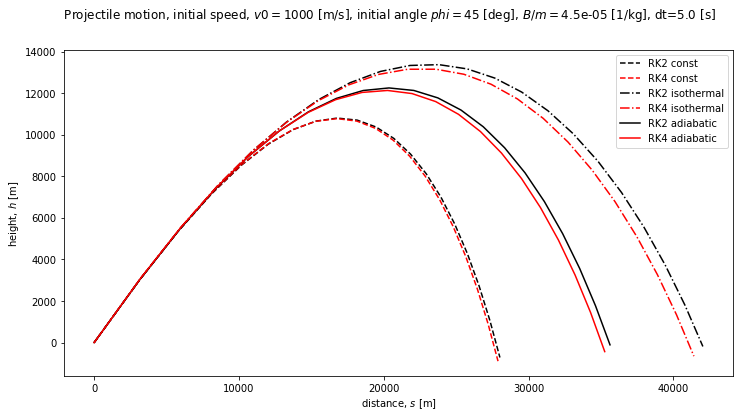

In [11]:
shapes  = {'const':'--','isothermal':'-.','adiabatic':'-'}
colours = {'Euler':'y','RK2':'k','RK4':'r'}

v0       =  1000   # Initial velocity (m/s)
phi_deg  = 45      # Initial angle (deg)
t0       = 0       # launch time (s)
t1       = 200.    # maximum duration of flight (s)
delta_t  = 5.0     # time-step of integrator (s)
B_m      = 4.5e-5  # Drag coeffecient divided by projectile's mass, B/m (1/kg)

# convert angle from degrees to radians
phi      = phi_deg * np.pi / 180.

# generate initial state vector
x0 = np.array([0, 0, v0*np.cos(phi), v0*np.sin(phi)])

# prepare plot and annotate with initial parameters
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

fig.suptitle(' Projectile motion, initial speed, $v0=$%s [m/s], initial angle $phi=$%s [deg], $B/m=$%s [1/kg], dt=%s [s]'
            %(
                v0,
                phi_deg,
                B_m,
                delta_t))
    
# plot horizontal distance,s, vs height, h
ax.set_ylabel(r'height, $h$ [m]')
ax.set_xlabel(r'distance, $s$ [m]')
    
def negativeY(x):
    return x[1] < 0


maxy=0
for airmodel in ['const','isothermal','adiabatic']:
    print ('Air model is:',airmodel)
    cannon = Cannonball(B_m,airmodel)

    for solverType,name in [
            (RK2Solver,'RK2'),
            (RK4Solver,'RK4')
    ]:
        solver = solverType(cannon)
        result = solver.solve(x0,t0,t1,delta_t,terminateCondition=negativeY)
        print ('Method %s:\tRange=%.6f m' % (name,cannon_range(solver)))

        xs,ys,_,_ = solver.coordinateSteps()
        ax.plot(xs, ys, shapes[airmodel]+colours[name],
                   label='%s %s'%(name,airmodel))

ax.legend()        
fig.savefig('trajectory.pdf')        



In [ ]:
# v0 =  np.arange(813.40, 813.41, 0.001) # Initial velocity (m/s)
# phi = 25 # Initial angle (deg)
# # phis= np.arange(12.6,12.8,0.01)
# # phis= np.arange(45.2,45.3,0.01)
# ranges=[]
# for v in v0: 
#    phir = phi * np.pi / 180. 
#    x0 = np.array([0, 0, v*np.cos(phir), v*np.sin(phir)])

#    t0 = 0.
#    t1 = 100.

#    B_m = 2e-5   # Drag coeffcient B/m (m^-1, realistic value is 4e-5)
#    deltat = 1e-3  # Size of timestep (s)
#    cannon=Cannonball(B_m, airmodel='adiabatic')
#    solver = RK4Solver(cannon)
#    solver.solve(x0,t0,t1,deltat,terminateCondition=negativeY)
#    ranges.append(cannon_range(solver))
# print(ranges)
# pylab.plot(v0,ranges)

# 
def func_solve(i):
    v0 = i # Initial velocity (m/s)
    phi = 25 # Initial angle (deg)
    # phis= np.arange(12.6,12.8,0.01)
    # phis= np.arange(45.2,45.3,0.01)
    ranges=[]
    phir = phi * np.pi / 180. 
    x0 = np.array([0, 0, v0*np.cos(phir), v0*np.sin(phir)])

    t0 = 0.
    t1 = 100.

    B_m = 2e-5   # Drag coeffcient B/m (m^-1, realistic value is 4e-5)
    deltat = 1e-3  # Size of timestep (s)
    cannon=Cannonball(B_m, airmodel='adiabatic')
    solver = RK4Solver(cannon)
    solver.solve(x0,t0,t1,deltat,terminateCondition=negativeY)
    print('Method %s:\tRange=%.6f m' % (name,cannon_range(solver)))
    return cannon_range(solver) - 33256

r = fsolve(func_solve, 800)
print(r)

The following questions is for **2 marks**

In [ ]:
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="test_ballistic";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve') or os.path.isfile('.choices.shelve.dir'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None

def make_value_change_fn(assessmentName,name):
    def fn(change):
        s=shelve.open('.choices.shelve')
        key='{0}_{1}'.format(assessmentName,name)
        s[key]=change['new']
        s.close()
    return fn
 
class myFloatBox:
    def __init__(self,name,description,long_description):
        self.name=name
        self.description=description
        self.long_description=long_description
    def getWidget(self):
        self.widgets=[ 
              widgets.FloatText(
              description=self.description,
        disabled=False,
                  value=get_last_value('{0}_{1}'.format(assessmentName,self.name))
        )]
        
        txt=widgets.HTMLMath(
            value=self.long_description,
            placeholder='',
            description='',
        )
        
        self.widget=VBox([txt]+self.widgets)
        self.widgets[0].observe(make_value_change_fn(assessmentName,self.name), names='value')

        return self.widget
    
mfb=myFloatBox('velocity','Velocity =',"Use the adiabatic air model "
               "with a value of B/m = 2e-5, and a launch angle of 25 degrees, compute "
               "the launch speed, $v0$, that yields a range of 33256.0 m. Give your answer accurate to "
               "6 significant digits. ")
mfb.getWidget()


Integrate the projectile using the following parameters:
  - v0       =  1000   # Initial velocity (m/s)
  - phi_deg  = 45      # Initial angle (deg)
  - t0       = 0       # launch time (s)
  - B_m      = 4.5e-5  # Drag coeffecient divided by projectile's mass, B/m (1/kg)

using the RK4 integrator. Determine the time step, delta_t, below which the range is accurate to better than 1 m.
Your answer should be accurate to within a factor of 2.

**2 marks**



In [ ]:
mfb2=myFloatBox('dt_rk4',"delta_t= ","Time step (s) below which RK4 is accurate to better than 1 m for our set-up "
               " Should be accurate to within a factor 2")
mfb2.getWidget()

In [ ]:
# v0       =  1000   # Initial velocity (m/s)
# phi_deg  = 45      # Initial angle (deg)
# t0       = 0       # launch time (s)
# t1       = 200.    # maximum duration of flight (s)
# delta_t  = 2.0     # time-step of integrator (s)
# B_m      = 4.5e-5  # Drag coeffecient divided by projectile's mass, B/m (1/kg)

# # first determine required accuracy of RK4 - delta_t=0.01 is accurate to better than 1 m
# phi      = phi_deg * np.pi / 180.
# delta_ts = 10.**(np.arange(-2.3,-2.2,0.01))
# ranges   = []
# for delta_t in delta_ts:
#     x0 = np.array([0, 0, v0*np.cos(phi), v0*np.sin(phi)])
#     t0      = 0.
#     t1      = 200.
#     print(delta_t)
#     cannon=Cannonball(B_m,airmodel='adiabatic')
#     solver = RK4Solver(cannon)
#     solver.solve(x0,t0,t1,delta_t,terminateCondition=negativeY)
#     ranges.append(solver.history[-1][1][0] - solver.history[-2][1][0])
   


# print(ranges)




0.005011872336272725
0.005128613839913648
0.005248074602497723
0.005370317963702522
0.005495408738576237
0.00562341325190348
0.0057543993733715545
0.005888436553555872
0.006025595860743556
0.006165950018614797
[0.955850375474256, 0.9781077386578545, 1.0009053845642484, 1.0242339912292664, 1.048080776054121, 1.0725446233118419, 1.0974999925892917, 1.1230486693093553, 1.1491784955796902, 1.1760121584593435]


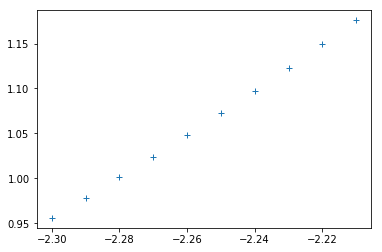

In [70]:
# now redo with RK2
delta_ts = 10.**(np.arange(-2.3,-2.2,0.01))
ranges   = []
for delta_t in delta_ts:
    x0 = np.array([0, 0, v0*np.cos(phi), v0*np.sin(phi)])
    t0      = 0.
    t1      = 200.
    print(delta_t)
    cannon=Cannonball(B_m,airmodel='adiabatic')
    solver = RK2Solver(cannon)
    solver.solve(x0,t0,t1,delta_t,terminateCondition=negativeY)
    ranges.append(solver.history[-1][1][0] - solver.history[-2][1][0])

print(ranges)    
pylab.plot(np.log10(delta_ts), ranges,'+')

Now use the RK2 integrator. Determine the time step, delta_t, below which its range is within 1 m of the RK4 answer.
Your answer should be accurate to within a factor of 2.

**2marks**


In [ ]:
mfb3=myFloatBox('dt_rk2',"delta_t= ","Time step (s) below which RK2 gives same answer as converged RK4 to within 1 m our set-up."
               " The answer should be accurate to within a factor of 2.")
mfb3.getWidget()

## Play area

Below is a play area - there are no marks to be collected. You may want to try-out the ballistic motion code you've written by computing and plotting different trajectories. As an example, investigate how the range depends on the mass of the projectile.

So far we have looked at the effect on drag on the projectile's flight. Also very relevant is the projectile's **spin**. Rafael Nadal manages to make a tennis ball spin at an almost unbelievable rate of 3000 rpm (rotations per minute). Spin is also crucial in golf. To increase range, players launch the ball with **back spin** at a rate of nearly 3000 rpm. This is so large that initially, the net acceleration on the golf ball is up, rather than down (that is, the force due to spin is larger than due to gravity). Develop a mathematical model for this, and implement it in your existing code.

